In [1]:
import sys
sys.path.append('../')
# import adaprobe
import holoprobe
import scipy
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# from importlib import reload
# reload(holoprobe.simulation)

In [3]:
N = 9 # number of cells
sigma = 3 # noise variance
spacing = 30 # minimum distance between cells
a = 0.75 # connection probability
sim = holoprobe.Simulation3d(N=N, sigma=sigma, spacing=spacing, a=a, mode='offline', filter_dim_len=20, dimx=200, dimy=200, dimz=100)

In [4]:
xs, ys, zs = sim.cell_locs[:, 0], sim.cell_locs[:, 1], sim.cell_locs[:, 2]

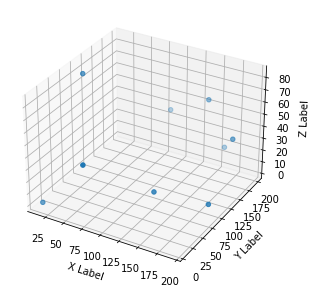

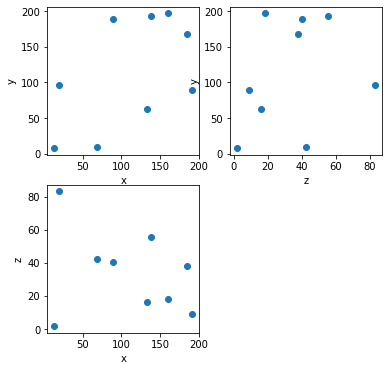

In [5]:
fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(projection='3d')
ax.scatter(xs, ys, zs, marker='o')
ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')
plt.show()

plt.figure(figsize=(6, 6))
plt.subplot(2, 2, 1)
plt.scatter(xs, ys)
plt.xlabel('x')
plt.ylabel('y')

plt.subplot(2, 2, 2)
plt.scatter(zs, ys)
plt.xlabel('z')
plt.ylabel('y')

plt.subplot(2, 2, 3)
plt.scatter(xs, zs)
plt.xlabel('x')
plt.ylabel('z')

plt.show()

In [6]:
K = 1000 # number of trials
powers = np.arange(10, 51, 10) # available laser powers
sim.simulate(trials=K, powers=powers)

In [7]:
spks = np.array(sim.spks).T
y = sim.y

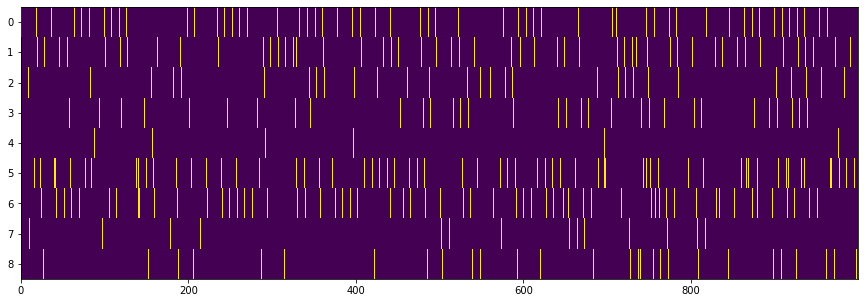

In [8]:
plt.figure(figsize=(15, 5))
plt.imshow(spks, aspect='auto', interpolation='nearest')
plt.show()

In [9]:
priors = {
    'alpha': 0.5 * np.ones(N),
    'mu': np.zeros(N),
    'beta': 2e1 * np.ones(N),
    'shape': 1,
    'rate': 1
#     'eta': sim.cell_filters
}

# priors = {
#     'alpha': np.ones(N),
#     'mu': sim.w,
#     'beta': 1e-1 * np.ones(N),
#     'shape': 1,
#     'rate': 1
# }

fit_options = {
    'iters': 50,
    'num_mc_samples': 10,
    'lam_update': 'monte-carlo'
}

# MAP is good w/ true filts

model = holoprobe.Model(sim.cell_locs, priors=priors)

In [10]:
model.fit(sim.y, (sim.L, sim.I), fit_options=fit_options)

In [11]:
lam = np.array(model.state['lam']).T

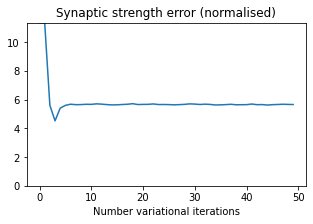

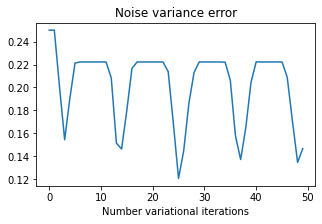

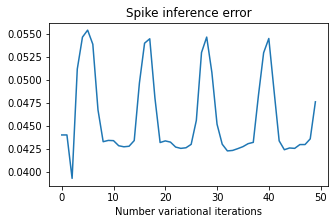

In [12]:
def plot_hist(model, sim):
    err = np.mean(np.abs(model.history['mu'] - sim.w), 1)
    plt.figure(figsize=(5, 3))
    plt.plot(err)
    plt.ylim([0, np.max(err)])
    plt.title('Synaptic strength error (normalised)')
    plt.xlabel('Number variational iterations')
    plt.show()
    
    plt.figure(figsize=(5, 3))
    plt.plot(np.mean(np.square(model.history['alpha'] - sim.z), 1))
    plt.title('Noise variance error')
    plt.xlabel('Number variational iterations')
    plt.show()
    
    spks = np.array(sim.spks).T
    spk_errs = np.array([np.mean(np.abs(model.history['lam'][:, n] - spks[n]), -1) for n in range(sim.N)])
    
    plt.figure(figsize=(5, 3))
    plt.plot(np.mean(spk_errs, 0), color='C0')
    plt.title('Spike inference error')
    plt.xlabel('Number variational iterations')
    plt.show()
    
plot_hist(model, sim)

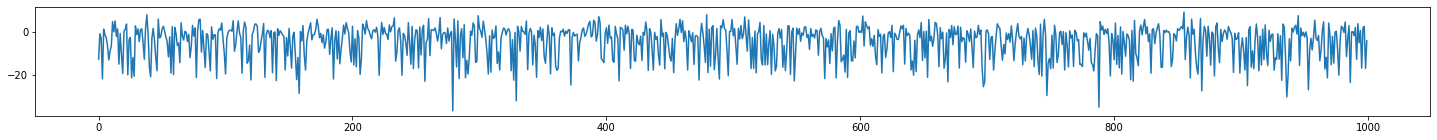

In [13]:
plt.figure(figsize=(25, 2))
plt.plot(sim.y[:1000])

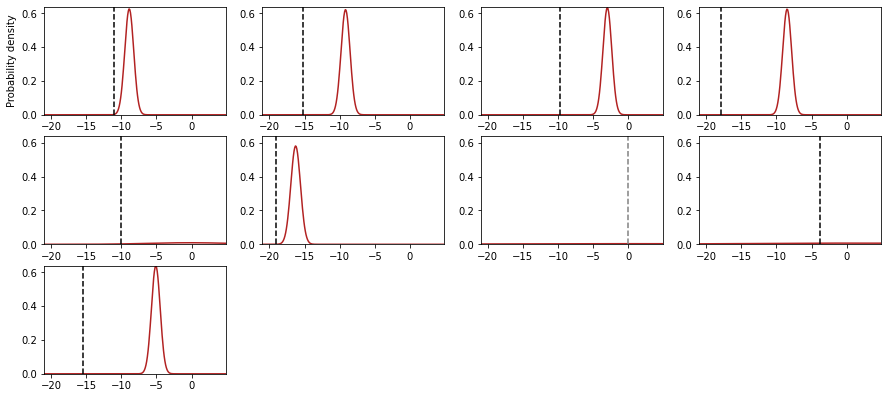

In [14]:
xrange = np.arange(-21, 5, 0.1)
def gaussf(mean, sdev):
    return 1/(np.sqrt(2 * np.pi * sdev**2)) * np.exp(-1/(2 * sdev**2) * (xrange - mean)**2)

def plot_connections(model, sim, legend=[]):    
    post = [model.state['alpha'][n] * gaussf(model.state['mu'][n], model.state['beta'][n]) for n in range(N)]
    postmax = np.max(post)
    plt.figure(figsize=(15, 3*(N/4)))
    for n in range(N):
        plt.subplot(int(np.ceil(N/4)), 4, n + 1)
        plt.plot(xrange, post[n], color='firebrick')
        true_col = 'gray' if sim.w[n] == 0 else 'black'
        plt.plot([sim.w[n], sim.w[n]], [0, postmax], '--', color=true_col)
        plt.xlim(np.min(xrange), np.max(xrange))
        plt.ylim([0, postmax])
        if n == 0:
            plt.xlabel('Synaptic strength')
            plt.ylabel('Probability density')
        if n == 0 and legend is not None:
            plt.legend(legend, loc='upper left', frameon=False)
    plt.show()

plot_connections(model, sim)

In [15]:
1/np.sqrt(model.state['shape']/model.state['rate'])

6.144825416026623

In [16]:
print(model.state['alpha'])

[1.         1.         0.99997749 1.         0.13248507 1.
 0.17395603 0.26757133 1.        ]


In [17]:
print(np.round(model.state['mu'], 2))
print(np.round(sim.w, 2))

[ -8.88  -9.17  -2.98  -8.47  -0.27 -16.27  -0.07  -0.17  -5.1 ]
[-11.05 -15.18  -9.7  -17.93 -10.05 -19.02  -0.    -3.74 -15.46]


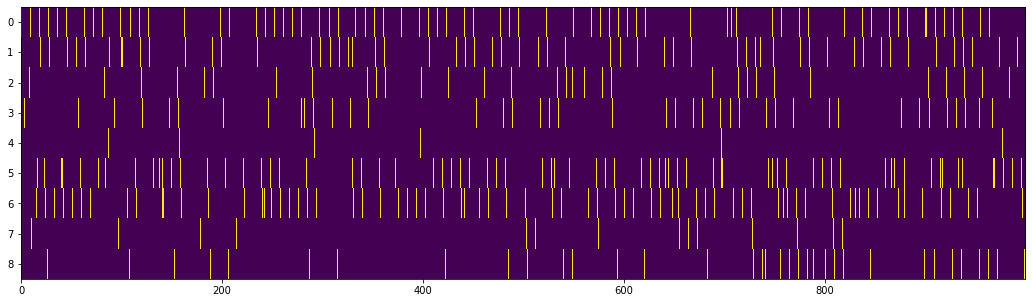

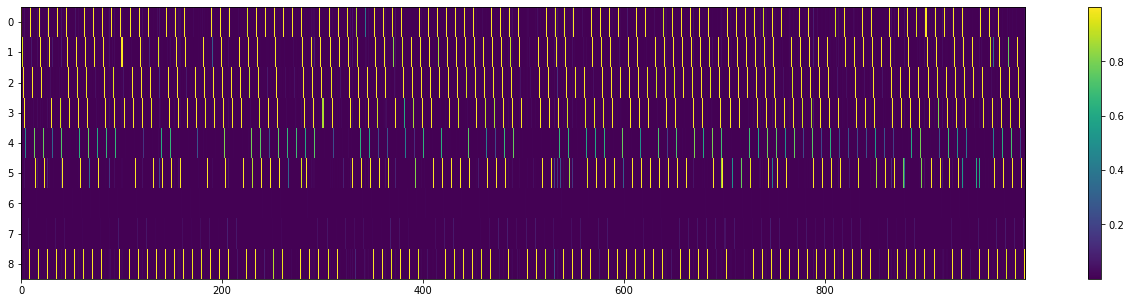

In [18]:
plt.figure(figsize=(18, 5))
plt.imshow(spks[:,:1000], aspect='auto', interpolation='nearest')
plt.show()

plt.figure(figsize=(22.5, 5))
plt.imshow(lam[:, :1000], aspect='auto', interpolation='nearest')
plt.colorbar()
plt.show()

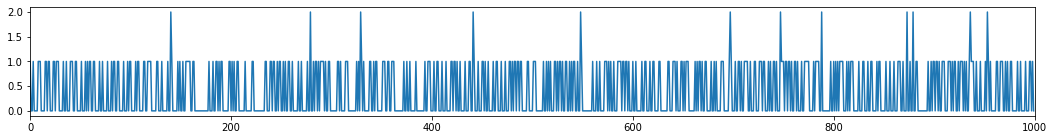

In [19]:
spks = np.array(sim.spks).T
plt.figure(figsize=(18, 2))
plt.plot(np.sum(spks, 0)[:1000])
plt.xlim([0, 1000])
plt.show()

[Text(0.5, 0, '0'), Text(1.5, 0, '1'), Text(2.5, 0, '2'), Text(3.5, 0, '3')]

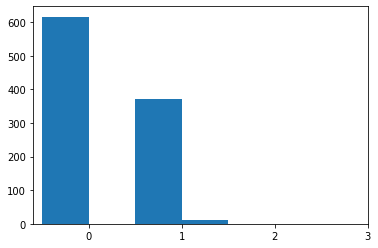

In [20]:
plt.hist(np.sum(spks, 0), 4)
plt.xticks(np.arange(4)+0.5)
plt.gca().set_xticklabels(np.arange(4))

In [21]:
def plot_spike_pred(model, sim, xlim=None):
    spks = np.array(sim.spks).T.astype(float) # true simulated spikes
    fr = np.array(sim.fr).T # true simulated firing rates
    lam = np.array(model.state['lam']).T # inferred firing rate
    s_pred = (lam >= 0.5).astype(float) # spike prediction
    for n in range(N):
        plt.figure(figsize=(25, 0.75))
        if sim.w[n] == 0:
            plt.plot(fr[n], color='gray') # disconnected cell
            plt.scatter(np.arange(len(spks[n])), spks[n], color='gray')
        else:
            plt.plot(fr[n], color='k') # connected cell
            plt.scatter(np.arange(len(spks[n])), spks[n], color='k')
        plt.plot(lam[n], '--', color='r')
        plt.scatter(np.arange(s_pred[0].shape[0]), s_pred[n], 50, marker='x', color='r')
        if xlim is not None:
            plt.xlim(xlim)
        else:
            plt.xlim([0, lam.shape[-1]])
        plt.ylim([0, 1.1])
        plt.show()

In [22]:
fr = np.array(sim.fr).T

(0.0, 1.0)

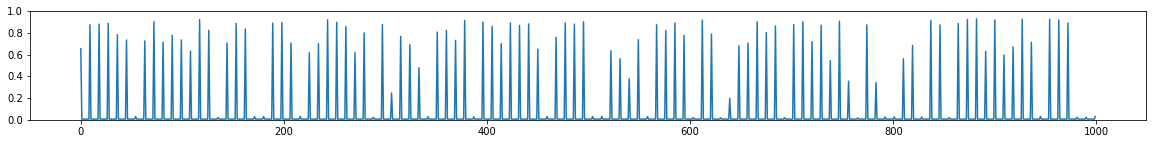

In [23]:
plt.figure(figsize=(20, 2))
plt.plot(fr[0])
plt.ylim([0, 1])

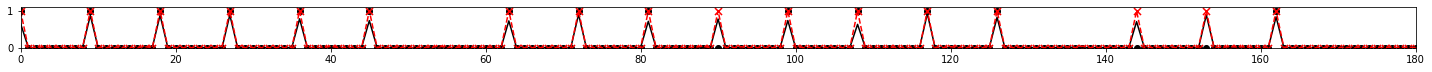

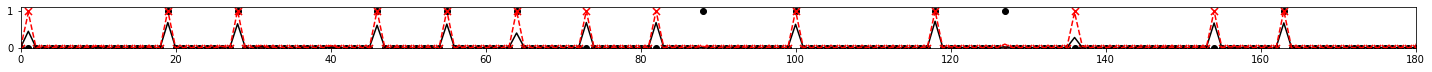

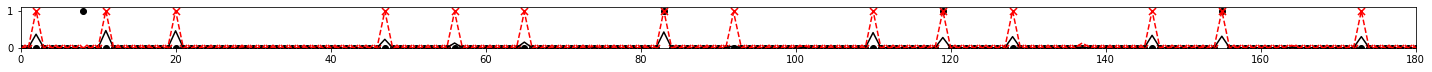

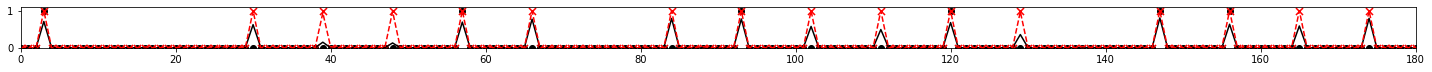

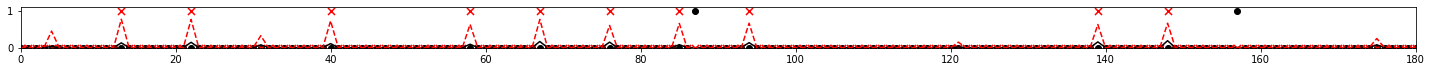

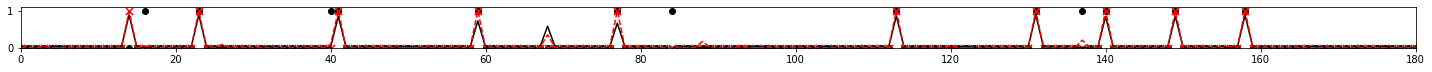

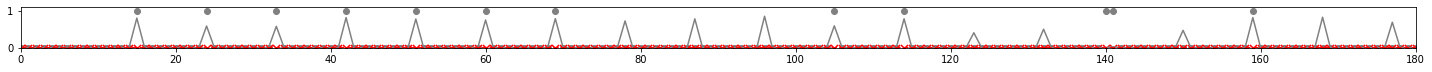

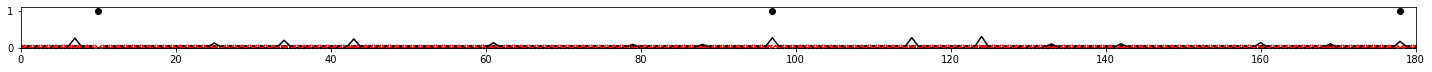

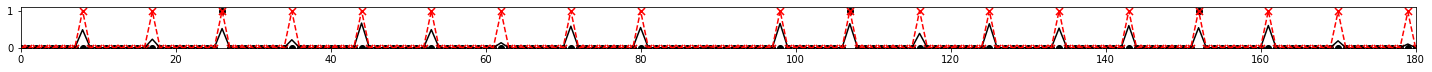

In [24]:
plot_spike_pred(model, sim, xlim=[0, 20*N])

In [25]:
model.state['eta'][:, -1]

array([5.49204188, 5.56009065, 5.45303436, 5.587552  , 5.91658729,
       5.3966293 , 6.29540845, 6.21149572, 5.46278455])

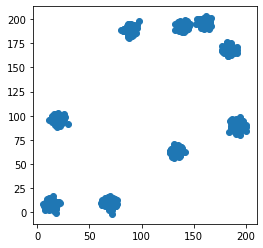

In [26]:
plt.figure(figsize=(4, 4))
plt.scatter(sim.L[:, 0], sim.L[:, 1])
# plt.xlim([0, 120])
# plt.ylim([0, 120])

In [27]:
model.state['eta'][-1]

array([0.14680527, 0.14868614, 0.14832839, 0.14578356, 0.21687844,
       0.22169016, 0.2210856 , 0.21504923, 0.23003141, 0.23544862,
       0.23492993, 0.22851469, 0.16620782, 0.16892675, 0.16886188,
       0.16598543, 0.21904969, 0.22397176, 0.22333799, 0.21722256,
       0.37737529, 0.38646537, 0.38581916, 0.37516803, 0.38743842,
       0.39586756, 0.39515957, 0.38539466, 0.24375847, 0.24976775,
       0.24987775, 0.24409167, 0.22089153, 0.22591627, 0.22540738,
       0.21945197, 0.36732786, 0.3755885 , 0.37501749, 0.36547078,
       0.37939051, 0.38955602, 0.38908442, 0.37802472, 0.23733051,
       0.24315422, 0.24314864, 0.23736514, 0.14903441, 0.15121125,
       0.15105133, 0.1485803 , 0.21123102, 0.21602364, 0.21566643,
       0.21019294, 0.21350558, 0.21849358, 0.21829035, 0.21291288,
       0.15584919, 0.1584013 , 0.15839699, 0.15583237, 5.46278455])

In [28]:
model.state['eta'][-2][2] * 20

1.9564390552874351

In [29]:
model.state['alpha'][-1]

0.9999999999999936

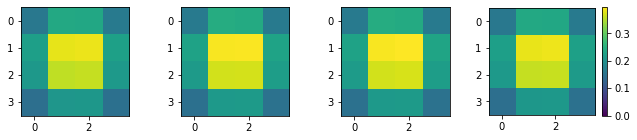

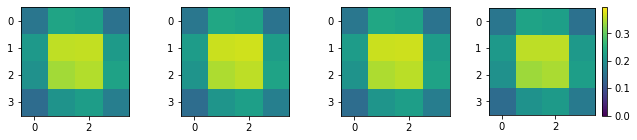

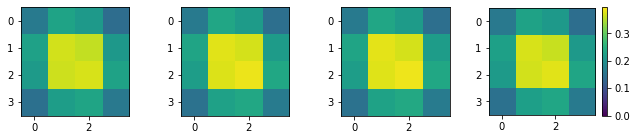

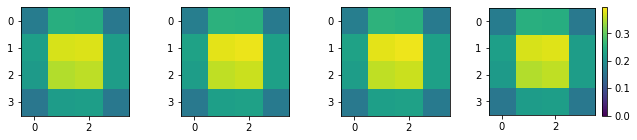

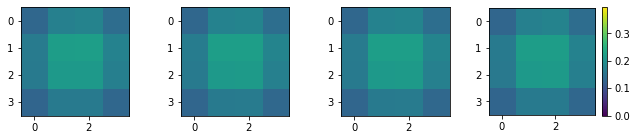

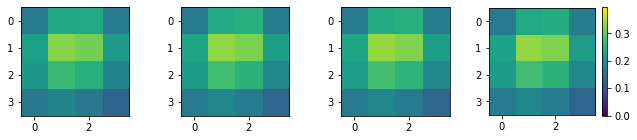

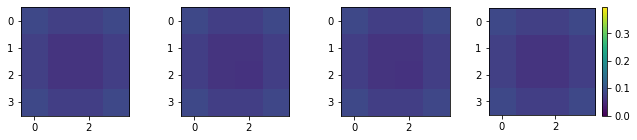

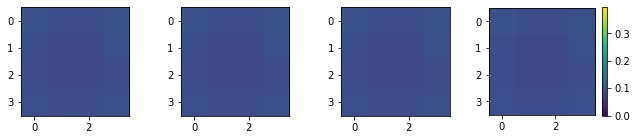

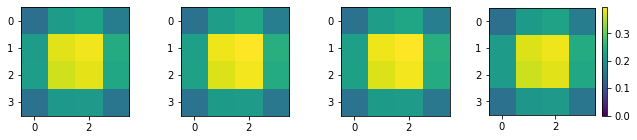

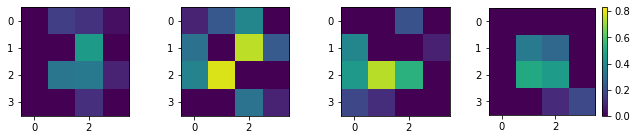

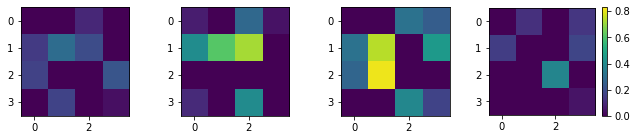

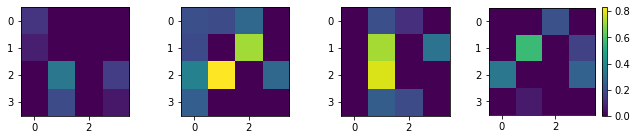

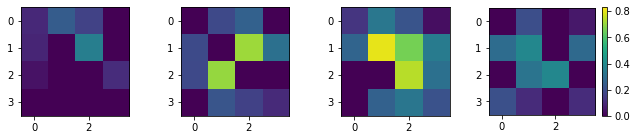

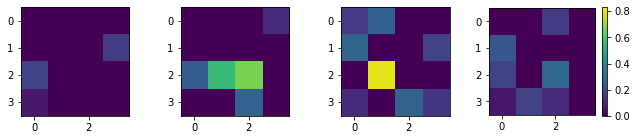

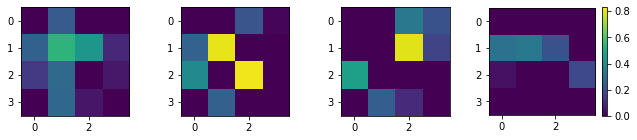

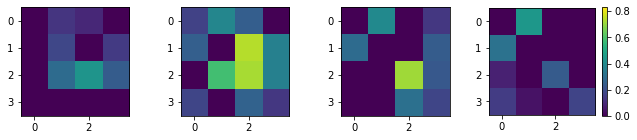

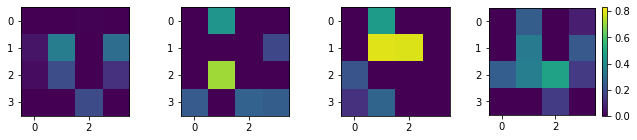

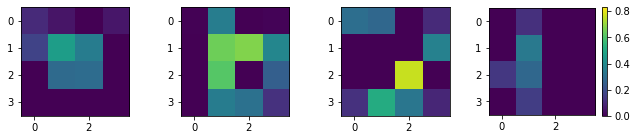

In [30]:
panel_width = 2
vmax_sim = np.max(sim.cell_filters[:, :-1])
vmax_mod = np.max(model.state['eta'][:, :-1])

for n in range(N):
    plt.figure(figsize=(4*panel_width + 3, panel_width))
    for d in range(4):
        plt.subplot(1, 4, d+1)
        plt.imshow(model.state['eta'][n][:-1].reshape([4, 4, 4])[..., d], vmin=0, vmax=vmax_mod)
    plt.colorbar()
    plt.show()
    
panel_width = 2
for n in range(N):
    plt.figure(figsize=(4*panel_width + 3, panel_width))
    for d in range(4):
        plt.subplot(1, 4, d+1)
        plt.imshow(sim.cell_filters[n][:-1].reshape([4, 4, 4])[..., d], vmin=0, vmax=vmax_sim)
    plt.colorbar()
    plt.show()

In [31]:
model.state['eta'][:, -1]

array([5.49204188, 5.56009065, 5.45303436, 5.587552  , 5.91658729,
       5.3966293 , 6.29540845, 6.21149572, 5.46278455])

In [32]:
sim.cell_filters[:, -1]

array([5.04598822, 5.00182658, 6.24989534, 6.61355412, 5.39741051,
       4.41244012, 4.97903323, 6.60470539, 6.21257206])

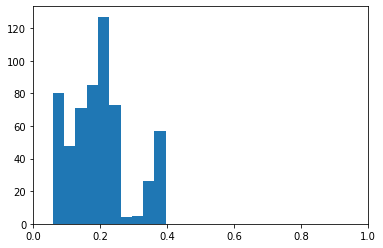

In [33]:
plt.hist(model.state['eta'][:, :-1].flatten())
plt.xlim([0, 1])
plt.show()

(0.0, 1.0)

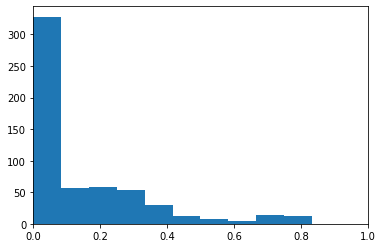

In [34]:
plt.hist(sim.cell_filters[:, :-1].flatten())
plt.xlim([0, 1])

In [35]:
eta_cov = model.state['eta_cov']

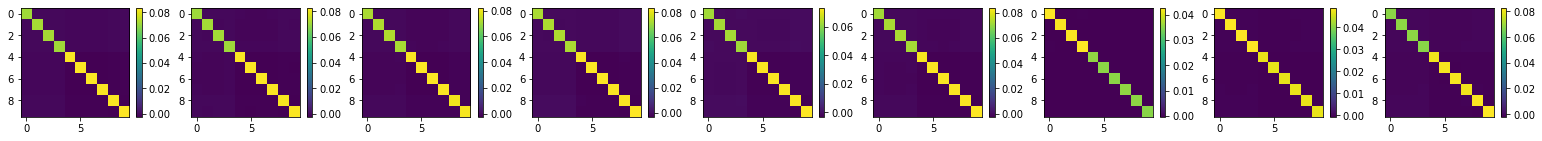

In [36]:

plt.figure(figsize=(N*3, 2))
for n in range(N):
    plt.subplot(1, N, n+1)
    plt.imshow(model.state['eta_cov'][n][:10, :10])
    plt.colorbar()
plt.show()